## update (02/05/2016): use Rf classification prob. as the matching degree.

In [13]:
from gensim import corpora, models, similarities
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
import gensim
import pickle

import time
import urllib2
from bs4 import BeautifulSoup
import itertools
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import psycopg2
import pandas as pd
import numpy as np
import sqlalchemy as sa
from sqlalchemy_utils import database_exists, create_database
%matplotlib inline

plt.rcParams['figure.figsize'] = 8, 5  # plotsize
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['font.size'] = 14

def text_cleaner(html): # return a single line of cleaned text
    '''
    This function just cleans up the raw html.
    Inputs: a URL to investigate
    Outputs: Cleaned text only after parsing, tokenization, lemmerization, remove stop-words
    '''
    try:
        site = urllib2.urlopen(html).read() # Connect to the job posting
    except:
        print "Error loading " + html
        return   # Need this in case the website isn't there anymore or some other weird connection problem 

    soup_obj = BeautifulSoup(site,"lxml") # Get the html from the site

    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
    
    text = soup_obj.body.get_text('\n') # Get the text from this

    lines = (line.strip() for line in text.splitlines()) # break into lines
#    lines = [line for i, line in enumerate(lines) if i>16]
#    for line in lines:
#        print line
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each
    
    def chunk_space(chunk):
        chunk_out = chunk + ' ' # Need to fix spacing issue
        return chunk_out  

    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends of line

    # Now clean out all of the unicode junk (this line works great!!!)
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception

    text = re.sub("[^a-zA-Z+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
                                                # Also include + for C++
        
    # remove the junk from the beginning and end parts of Indeed
    try:
        text = ((text.lower()).split('advanced search')[1]).split('save resume')[0]
    except:
        return text
    
    return text

def Preprocessing_line(line): # perform tokenization, select noun, Lemmertization etc on a line text
    rtext=[]    
    for w, tag in nltk.pos_tag(nltk.word_tokenize(line.lower())):  # Tokenization
        if tag in ['NN']:  # Keep only Nouns (for this special case)
            rtext.append(w)
    
    wordnet_lemmatizer = WordNetLemmatizer()  # Lemmertization
    rtext = [wordnet_lemmatizer.lemmatize(w) for w in rtext]
            
    stop_words = set(stopwords.words("english")) # Filter out any stop words
    rtext = [w for w in rtext if not w in stop_words]
    
    return rtext # return list of tokens

## Similarity query in Latent Topic vector space using LSI

In [14]:
from collections import Counter
jobclass=['Data Scientist', 'Software Engineer', 'Consultant', 'Strategy Manager']
job2id ={}
for i,jt in enumerate(jobclass):
    job2id[jt]=i

def LSI_Match(html,targetjob='Data Scientist'):
    ## 1. Load the corpus dictionary, job2keywords dict, and jobs table
    j=1
    path = '/home/hxzheng/Insight_DS_Fellowship/Project/JobRecomm/Resume_text/'
    dictionary = gensim.corpora.Dictionary.load(path + 'dict'+str(j)+'.dict')
    mm = gensim.corpora.MmCorpus(path + 'corpus'+str(j)+'.mm')
    tfidfmodel = models.TfidfModel.load(path + 'tfidfmodel'+str(j)+'.tfidf')
    
    jobs=pd.read_pickle(path + 'jobs_table.dat')
    jobid2keywords = pickle.load(open(path + 'jobid2keywords_freq.txt','rb'))

    ## 2. Load the trained LSI model index
    lsi = models.LsiModel.load(path + 'final_lsimodel.lsi')
    index = similarities.MatrixSimilarity.load(path + 'final_lsimodel.index')

    ## 3. Prepare the input document
    line = text_cleaner(html)
#    print line
    doc = Preprocessing_line(line)
    vec_bow = dictionary.doc2bow(doc)
    vec_lsi = lsi[tfidfmodel[vec_bow]] # convert the query to tfidf->LSI space
    x_lsi = [weight for _,weight in vec_lsi]
    
    ## 4.Perform a resume classification and use the probability as matching degree
    RF_Model=pd.read_pickle(path+'Final_RF_LSIMODEL.pkl')  
    ypred_proba = RF_Model.predict_proba(x_lsi)
    ypred_proba = ypred_proba[0]
    
    jobid_tj = job2id[targetjob]
    jobid_bm = np.argmax(ypred_proba)
    jobtitle_bm = jobclass[jobid_bm]
    
    matchdegree_bm = ypred_proba[jobid_bm]
    matchdegree_tj = ypred_proba[jobid_tj]

    missing_keywords_bm = [w for w in jobid2keywords[jobtitle_bm] if (' '+w+' ' not in line and w not in doc)]
    match_keywords_bm = [w for w in jobid2keywords[jobtitle_bm] if w not in missing_keywords_bm]
    
#    print missing_keywords_bm
#    print match_keywords_bm
    
    if targetjob==jobtitle_bm:
        missing_keywords_tj, match_keywords_tj =missing_keywords_bm, match_keywords_bm
    else:  # search for the target job matching prob
        missing_keywords_tj = [w for w in jobid2keywords[targetjob] if (' '+w+' ' not in line and w not in doc)]
        match_keywords_tj = [w for w in jobid2keywords[targetjob] if w not in missing_keywords_tj]
    
    return jobtitle_bm, matchdegree_bm, missing_keywords_bm, match_keywords_bm, matchdegree_tj, missing_keywords_tj,match_keywords_tj    

In [15]:
t=time.time()
html = 'http://www.indeed.com/r/Vadim-s/f365459c83af555d'
targetjob='Consultant'
jobtitle_bm, matchdegree_bm, missing_keywords_bm, match_keywords_bm,matchdegree_tj, missing_keywords_tj,match_keywords_tj = LSI_Match(html,targetjob=targetjob)
print "Matching degree with %s is %.2f"%(jobtitle_bm,matchdegree_bm)
print "Matching keywords are:"
print match_keywords_bm
print "Missing keywords are:"
print missing_keywords_bm
print '\n'
print "Matching degree with %s is %.2f"%(targetjob,matchdegree_tj)
print "Matching keywords are:"
print match_keywords_tj
print "Missing keywords are:"
print missing_keywords_tj
print '\n\n'
print "Done with %.2f seconds"%(time.time()-t)

html = 'http://www.indeed.com/r/Shrujal-Agrawal/eef26e9440470fc6'

targetjob="Consultant"
jobtitle_bm, matchdegree_bm, missing_keywords_bm, match_keywords_bm,matchdegree_tj, missing_keywords_tj,match_keywords_tj = LSI_Match(html,targetjob=targetjob)
print "Matching degree with %s is %.2f"%(jobtitle_bm,matchdegree_bm)
print "Matching keywords are:"
print match_keywords_bm
print "Missing keywords are:"
print missing_keywords_bm
print '\n'
print "Matching degree with %s is %.2f"%(targetjob,matchdegree_tj)
print "Matching keywords are:"
print match_keywords_tj
print "Missing keywords are:"
print missing_keywords_tj
print '\n'

/home/hxzheng/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/hxzheng/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Matching degree with Data Scientist is 0.74
Matching keywords are:
['r', 'python', 'machine learning', 'algorithm', 'data mining', 'regression', 'modeling', 'hadoop', 'visualization', 'tableau', 'decision', 'java', 'sql', 'information', 'implementation', 'design', 'customer']
Missing keywords are:
['artificial intelligence', 'data processing', 'optimization', 'c++', 'enterprise', 'health', 'network', 'technology']


Matching degree with Consultant is 0.07
Matching keywords are:
['risk', 'training', 'planning', 'information', 'design', 'integration', 'customer']
Missing keywords are:
['marketing', 'communication', 'organization', 'network', 'technology', 'insurance', 'inventory', 'cash', 'review', 'leadership', 'compliance', 'health care', 'preparation']



Done with 3.67 seconds
Matching degree with Software Engineer is 0.49
Matching keywords are:
['c++', 'code', 'implementation', 'automation', 'design', 'html', 'testing', 'architecture', 'information']
Missing keywords are:
['java', '

## Similarity query in Bag-of-word vector space

In [16]:
def bow_sim(text1, text2):  #input: text1 and text2 are one-line document file
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]  # return the bag-of-word(bow) similarity score [0,1]

In [17]:
def mostsim(doc, Corpusfile, num=10):
    path = '/home/hxzheng/Insight_DS_Fellowship/Project/JobRecomm/Resume_text/'
    scores=[]
    texts = pd.read_pickle(path + 'texts_b4tfidf.txt')
    for line in f:
        scores.append( bow_sim(doc, ''.join(line)) )
        
    docnum=sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:num]   
    f.close()
    
    return sorted(scores, reverse=True)[:num], docnum

In [18]:
# Return num_topics most significant topics. For each topic, show num_words most significant words
# lsi.show_topics(num_topics=-1, num_words=10)

In [19]:
match_keywords_bm

['c++',
 'code',
 'implementation',
 'automation',
 'design',
 'html',
 'testing',
 'architecture',
 'information']

/home/hxzheng/anaconda2/lib/python2.7/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


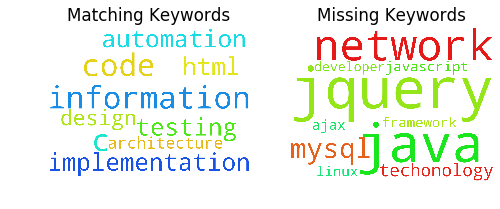

In [20]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

text1 = ' '.join(match_keywords_bm)
text2 = ' '.join(missing_keywords_bm)

fig = plt.figure()

wordcloud1 = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=1800,
                      height=1400
                     ).generate(text1)
wordcloud2 = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=1800,
                      height=1400
                     ).generate(text2)

plt.subplot(121)
plt.imshow(wordcloud1)
plt.axis('off')
plt.title('Matching Keywords')

plt.subplot(122)
plt.imshow(wordcloud2)
plt.axis('off')
plt.title('Missing Keywords')

plt.savefig('./misskeywords_wordcloud_1.png', dpi=300)
plt.show()


In [21]:
fig.savefig('./misskeywords_wordcloud_2.png', dpi=300)